In [1]:
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("../"))

from scripts.evaluate import evaluate_forecasts
from scripts.visualization import *

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
df_brl = pd.read_parquet('../data/all_comm/comm_brl.parquet')
df_usd = pd.read_parquet('../data/all_comm/comm_usd.parquet')

### BRL

In [4]:
Y_test_df_brl = df_brl.groupby('unique_id').tail(24)
remaining = df_brl.drop(Y_test_df_brl.index, axis = 0)
X_val_df_brl = remaining.groupby('unique_id').tail(12)
X_train_df_brl = remaining.drop(X_val_df_brl.index, axis=0)

In [5]:
X_train_df_brl.head()

,ds,y,unique_id
0,2003-05-01,28.156667,ACUCAR
1,2003-06-01,25.092000,ACUCAR
2,2003-07-01,23.928636,ACUCAR
3,2003-08-01,29.410000,ACUCAR
4,2003-09-01,24.313636,ACUCAR


In [6]:
from statsforecast import StatsForecast
                
from statsforecast.models import (
    Naive,
    AutoARIMA
)

/home/matt/anaconda3/envs/smp-commodities/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
models = [
    Naive(),
    AutoARIMA(season_length=12)
]

In [8]:
sf = StatsForecast( 
    models=models,
    freq='ME',
)

In [9]:
forecasts_val = sf.forecast(df=X_train_df_brl, h=12, fitted=True)
forecasts_val.head(12)

,unique_id,ds,Naive,AutoARIMA
0,ACUCAR,2022-02-28,144.78,141.706969
1,ACUCAR,2022-03-31,144.78,141.694958
2,ACUCAR,2022-04-30,144.78,142.449878
3,ACUCAR,2022-05-31,144.78,142.879406
4,ACUCAR,2022-06-30,144.78,143.020806
5,ACUCAR,2022-07-31,144.78,145.034143
6,ACUCAR,2022-08-31,144.78,147.255139
7,ACUCAR,2022-09-30,144.78,148.489071
8,ACUCAR,2022-10-31,144.78,150.358807
9,ACUCAR,2022-11-30,144.78,150.653070


In [10]:
full_train = pd.concat([X_train_df_brl, X_val_df_brl])
forecasts_test = sf.forecast(df=full_train, h=24, fitted=True)

In [11]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head(10)

,unique_id,ds,y,Naive,AutoARIMA
0,ACUCAR,2003-05-01,28.156667,NaN,28.128510
1,ACUCAR,2003-06-01,25.092000,28.156667,27.770887
2,ACUCAR,2003-07-01,23.928636,25.092000,23.824496
3,ACUCAR,2003-08-01,29.410000,23.928636,24.079414
4,ACUCAR,2003-09-01,24.313636,29.410000,32.159257
5,ACUCAR,2003-10-01,21.140435,24.313636,20.113904
6,ACUCAR,2003-11-01,20.375500,21.140435,21.679392
7,ACUCAR,2003-12-01,21.424500,20.375500,19.691115
8,ACUCAR,2004-01-01,19.659524,21.424500,22.330977
9,ACUCAR,2004-02-01,18.176111,19.659524,18.222120


In [12]:
metrics_df = pd.DataFrame()

for commodity in Y_test_df_brl['unique_id'].unique():
    actual = Y_test_df_brl[Y_test_df_brl['unique_id'] == commodity]['y']
    
    for model in ['Naive', 'AutoARIMA']:
        pred = forecasts_test[forecasts_test['unique_id'] == commodity][model]
        metrics = evaluate_forecasts(actual, pred)
        
        temp_df = pd.DataFrame({
            'Commodity': [commodity],
            'Model': [model],
            'MAE': [metrics['MAE']],
            'MAPE': [metrics['MAPE']],
            'MSE': [metrics['MSE']],
            'RMSE': [metrics['RMSE']],
            'R2': [metrics['R2']]
        })
        
        metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)

metrics_df = metrics_df.round(4)

In [21]:
print("Métricas de Erro por Commodity e Modelo:")
metrics_df

Métricas de Erro por Commodity e Modelo:


,Commodity,Model,MAE,MAPE,MSE,RMSE,R2
0,ACUCAR,Naive,13.8226,0.0912,275.2721,16.5913,-2.1456
1,ACUCAR,AutoARIMA,12.2199,0.0806,218.0784,14.7675,-1.4921
2,ALGODAO,Naive,118.0222,0.2947,14338.8836,119.7451,-34.0030
3,ALGODAO,AutoARIMA,119.9466,0.2990,14845.0787,121.8404,-35.2387
4,CAFE,Naive,350.5870,0.2394,265077.8146,514.8571,-0.1003
5,CAFE,AutoARIMA,336.9384,0.2488,214624.9801,463.2764,0.1091
6,MILHO,Naive,21.7073,0.3599,539.7653,23.2328,-6.8730
7,MILHO,AutoARIMA,21.5920,0.3580,534.6450,23.1224,-6.7983
8,SOJA,Naive,33.8499,0.2497,1233.3311,35.1188,-13.0933
9,SOJA,AutoARIMA,41.6510,0.3071,1882.5360,43.3882,-20.5117


In [14]:
print("\nMétricas Médias por Modelo:")
print(metrics_df.groupby('Model')[['MAE', 'RMSE', 'MAPE', 'R2']].mean().round(4))


Métricas Médias por Modelo:
                MAE     RMSE    MAPE       R2
Model                                        
AutoARIMA  106.4696  133.279  0.2587 -12.7863
Naive      107.5978  141.909  0.2470 -11.2430


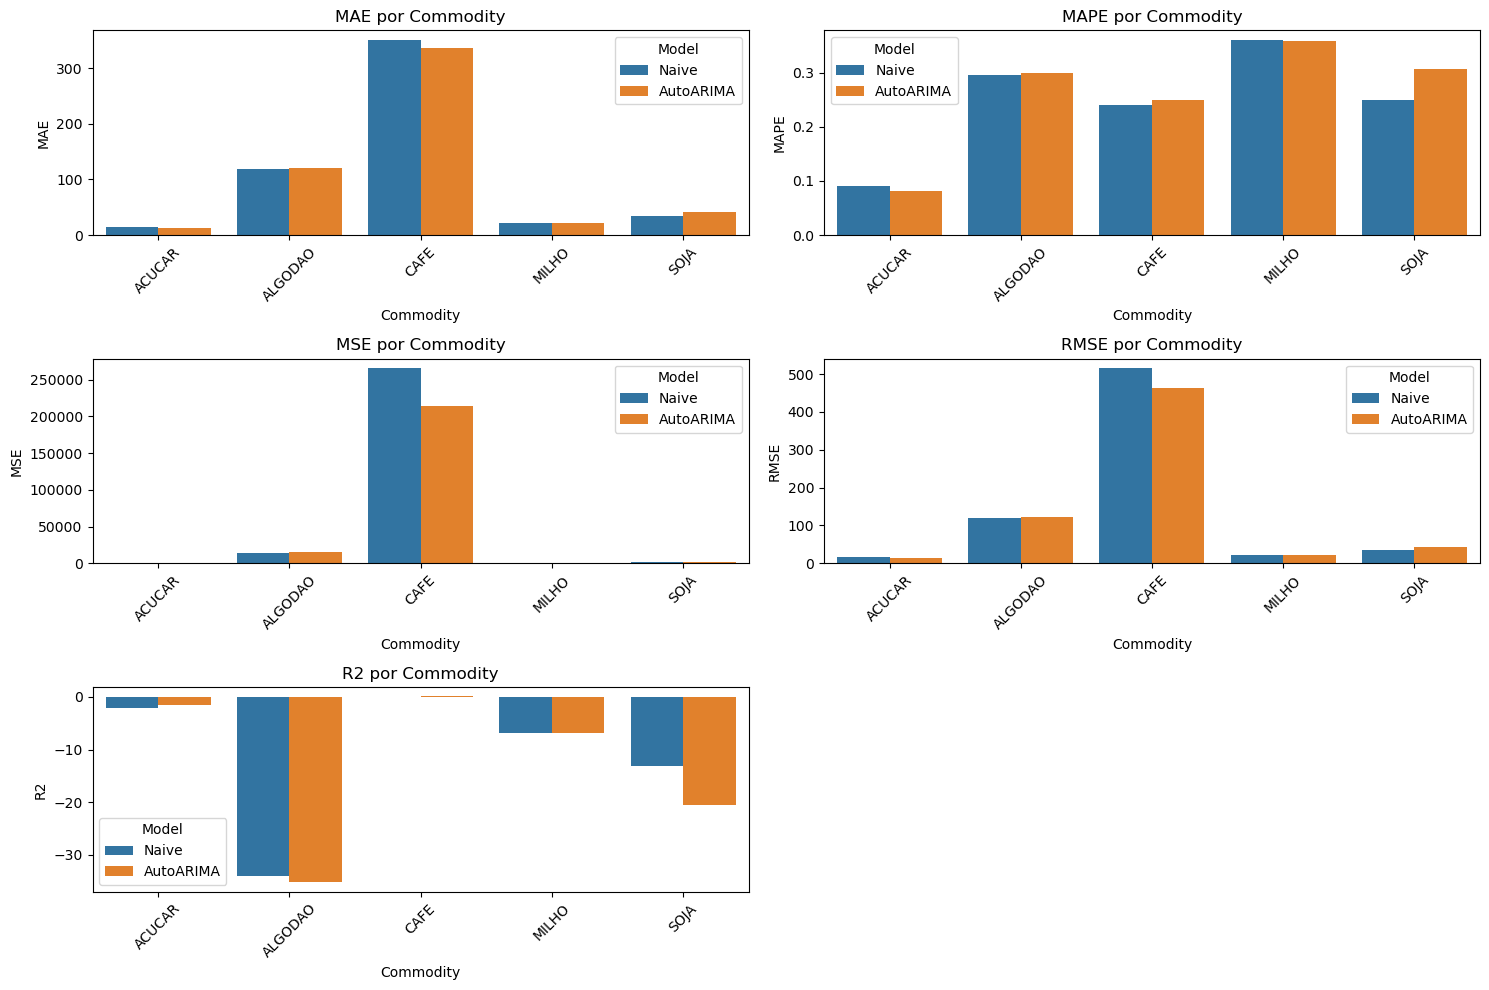

In [15]:
plot_metrics_comparison(metrics_df)

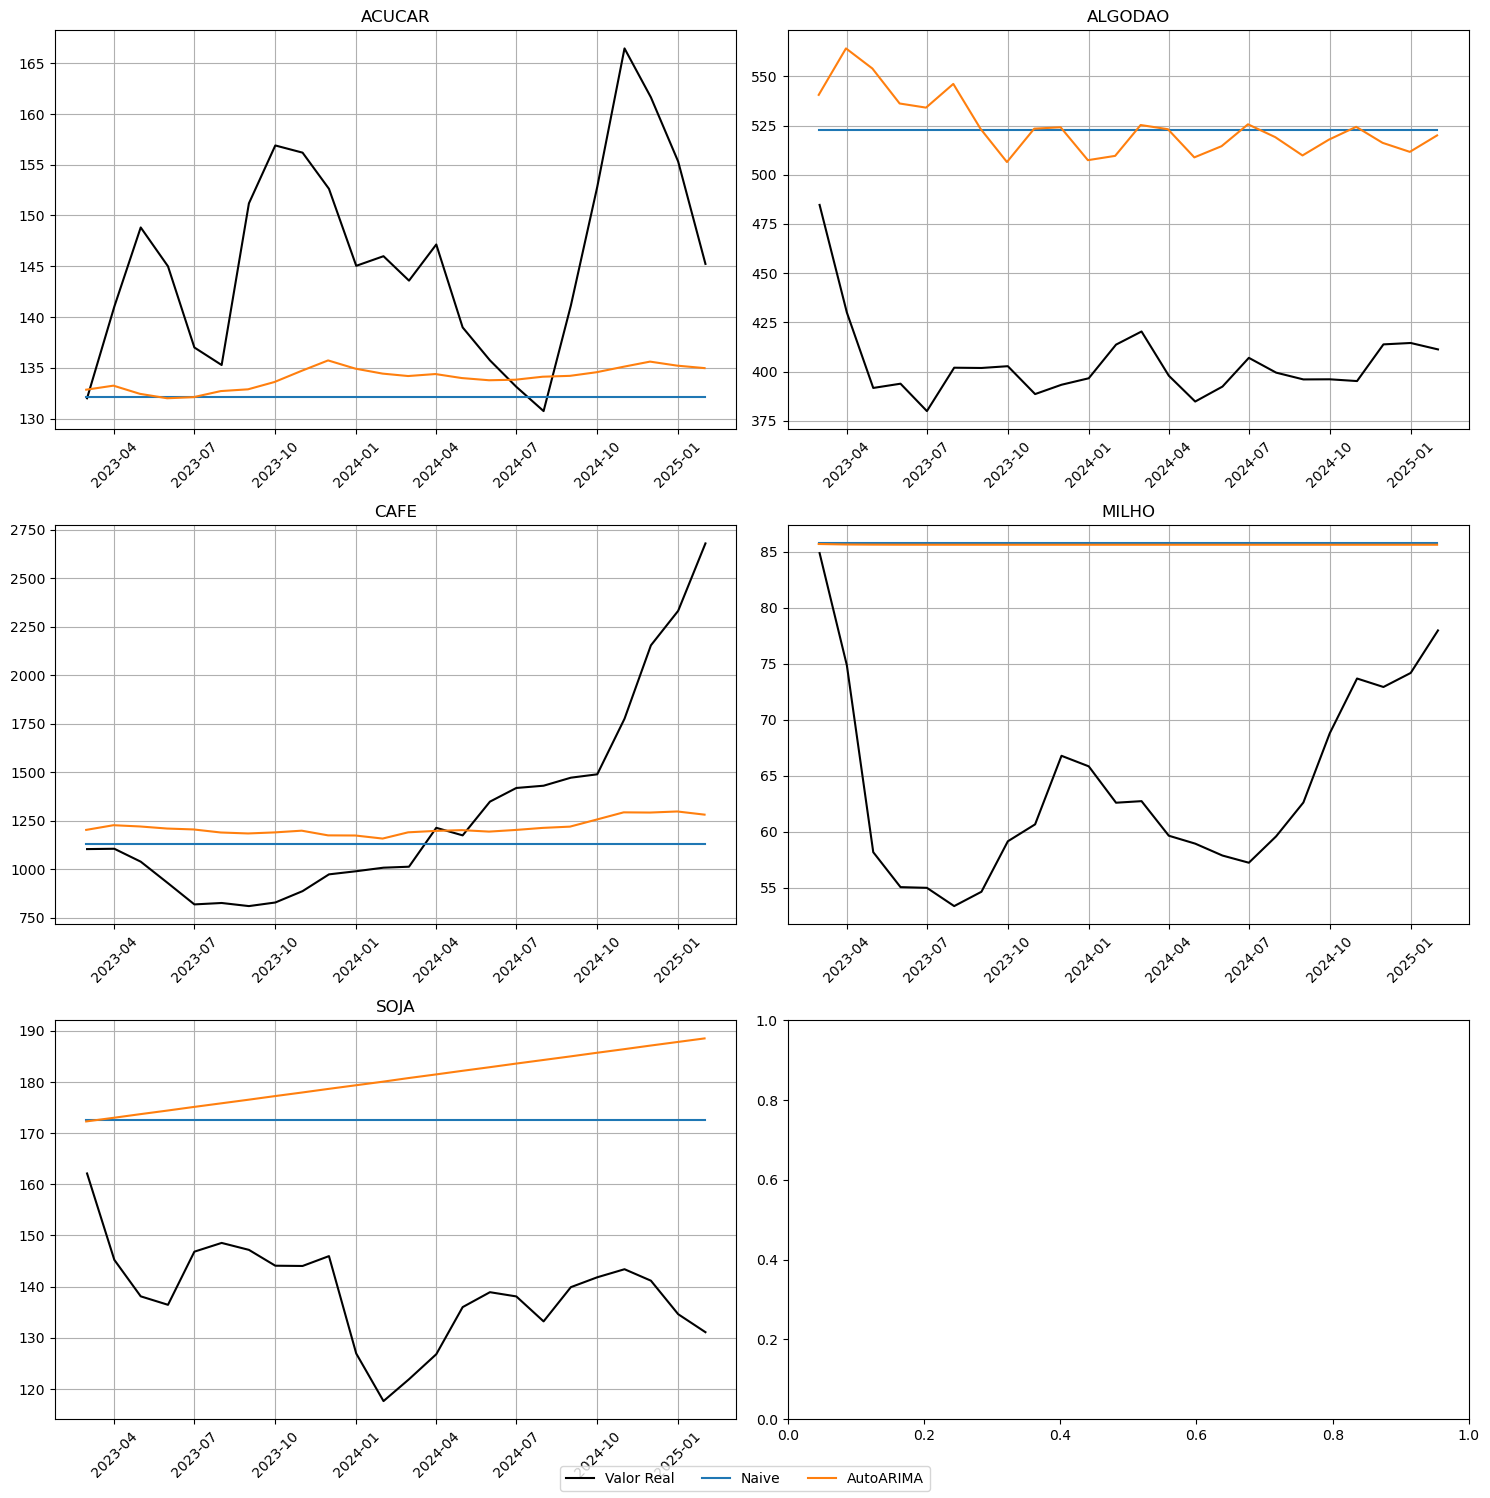

In [16]:
commodities = Y_test_df_brl['unique_id'].unique()
plot_forecasts_grid(
    actual=Y_test_df_brl,
    forecasts=forecasts_test,
    models=['Naive', 'AutoARIMA'],
    commodities=commodities
)

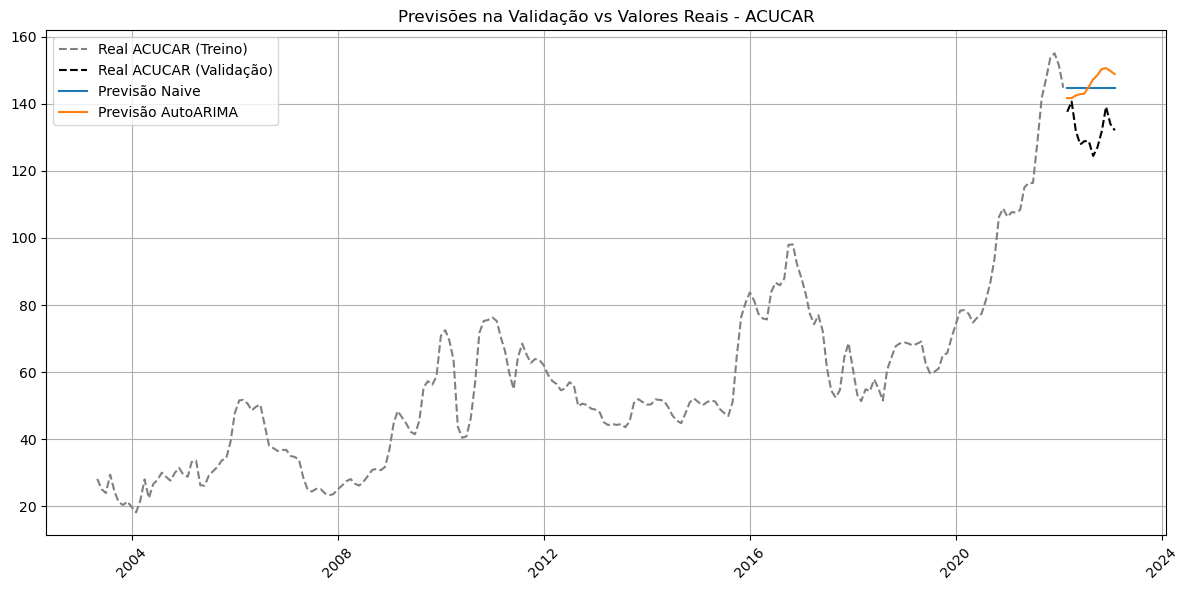

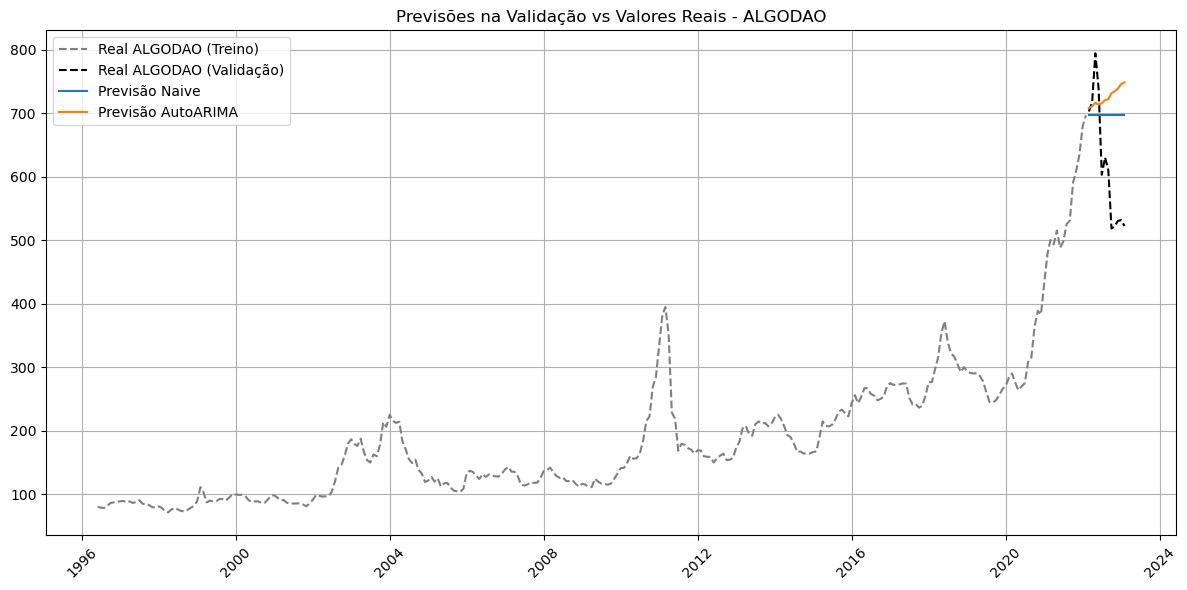

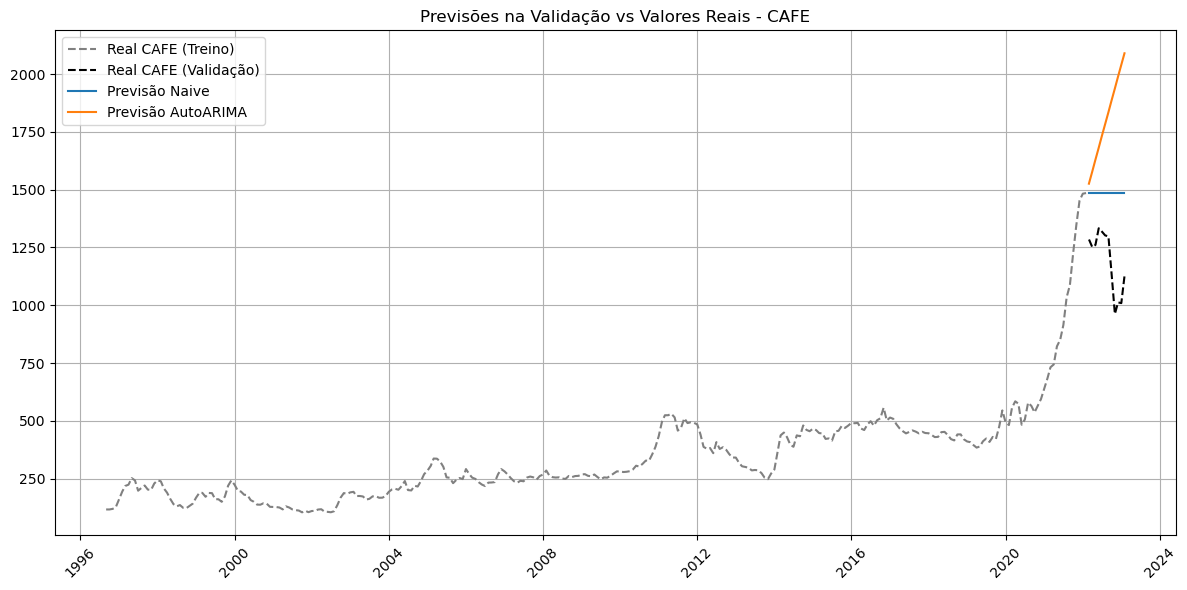

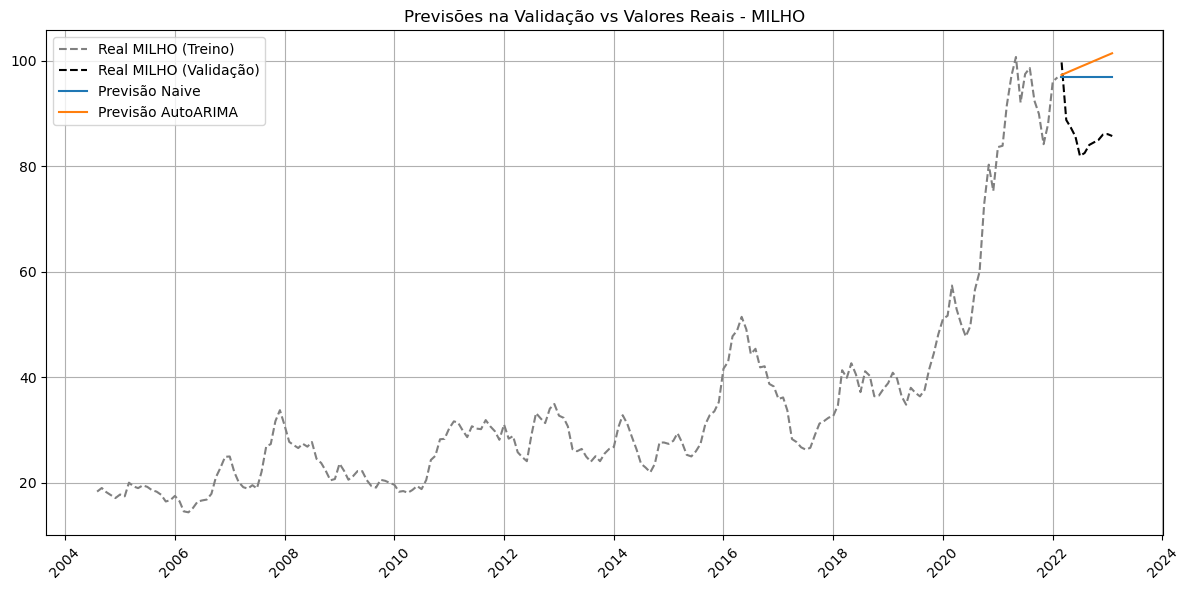

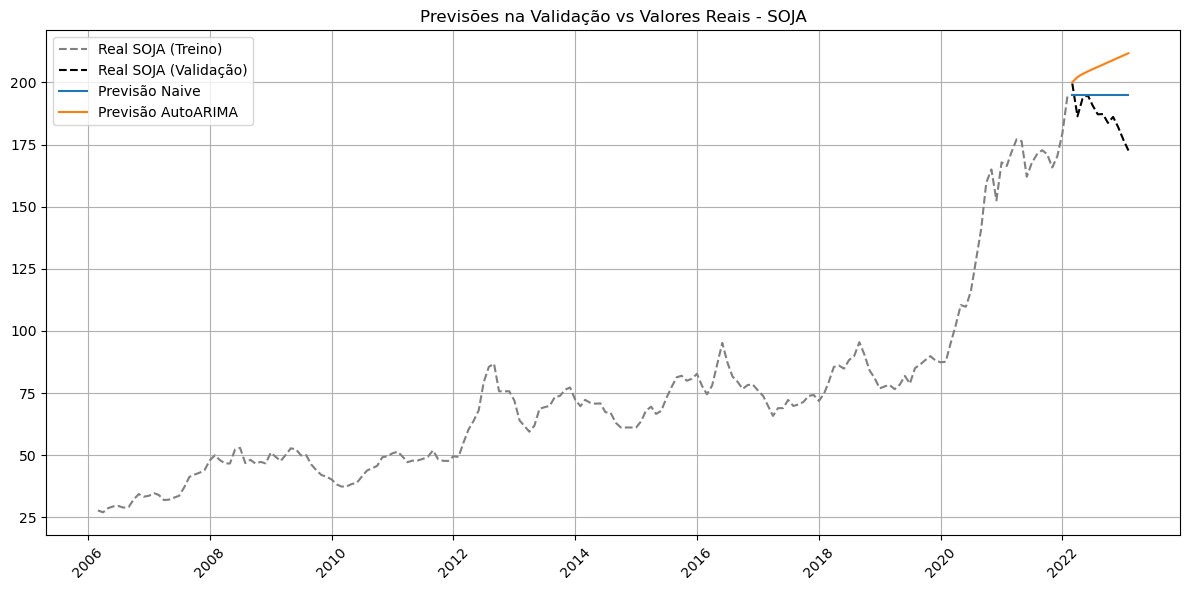

In [17]:
for commodity in X_val_df_brl['unique_id'].unique():
    plot_validation_forecasts(
        train_data=X_train_df_brl,
        val_data=X_val_df_brl,
        forecasts_val=forecasts_val,
        commodity=commodity
    )

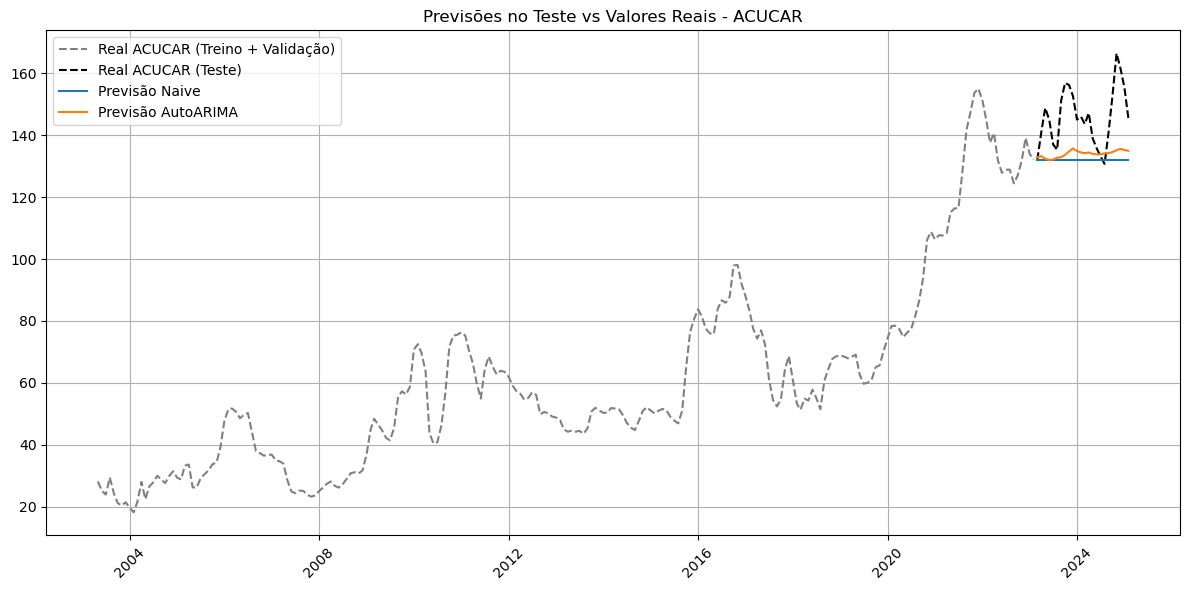

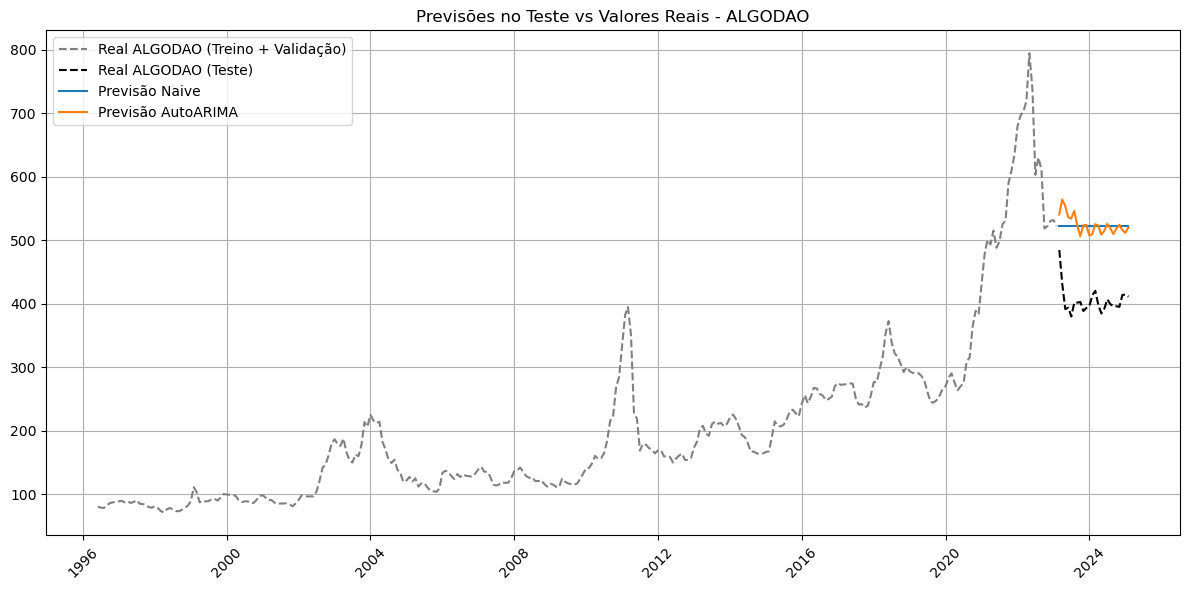

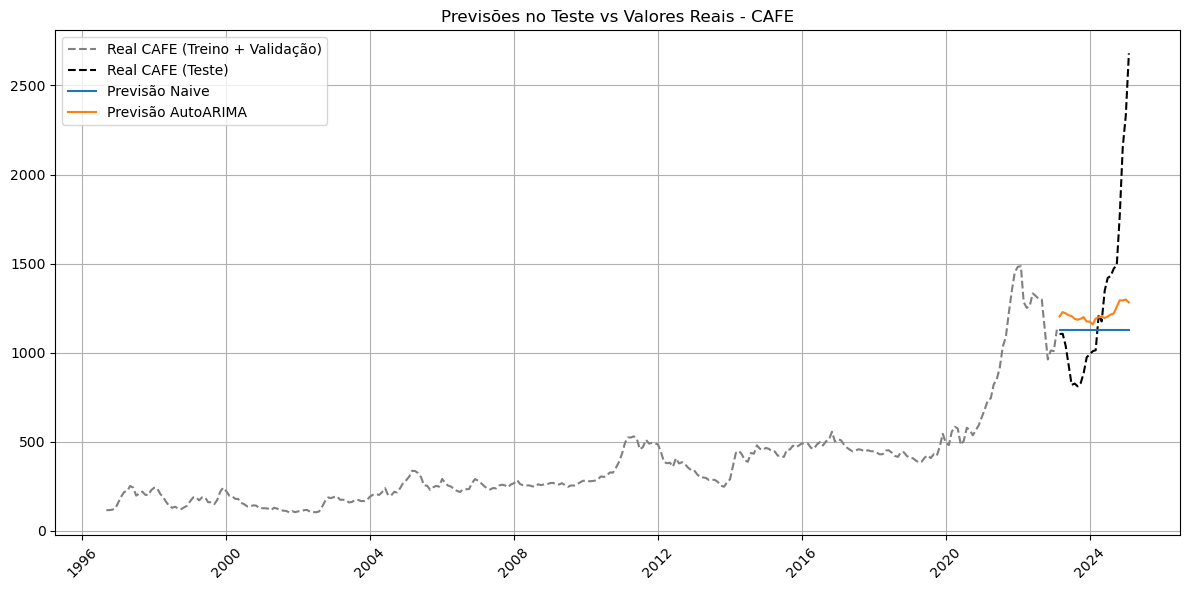

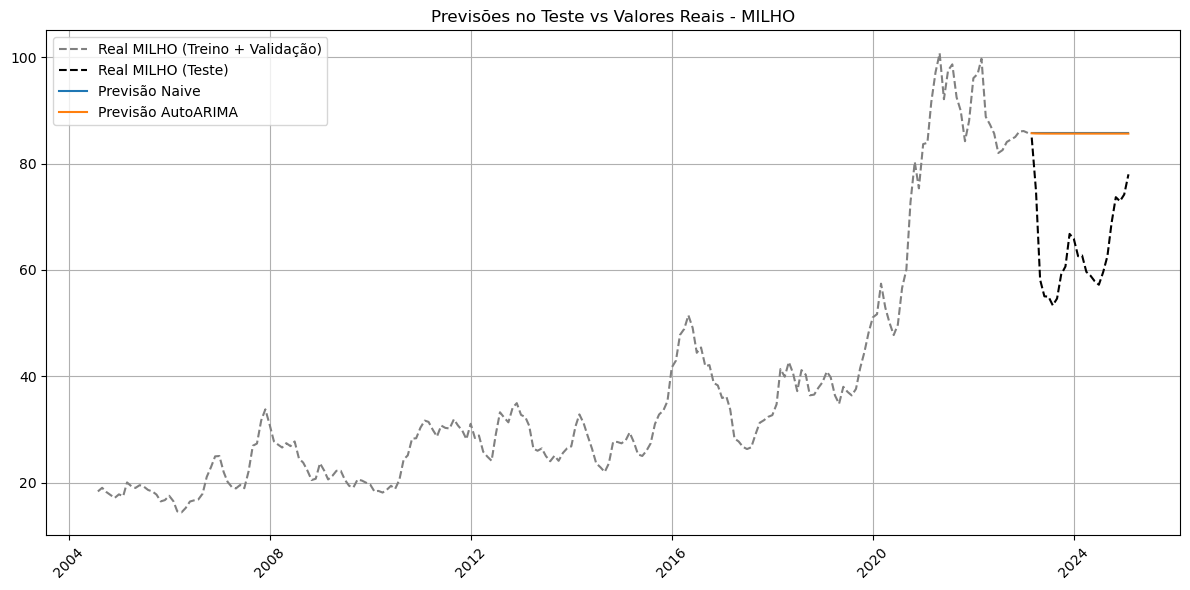

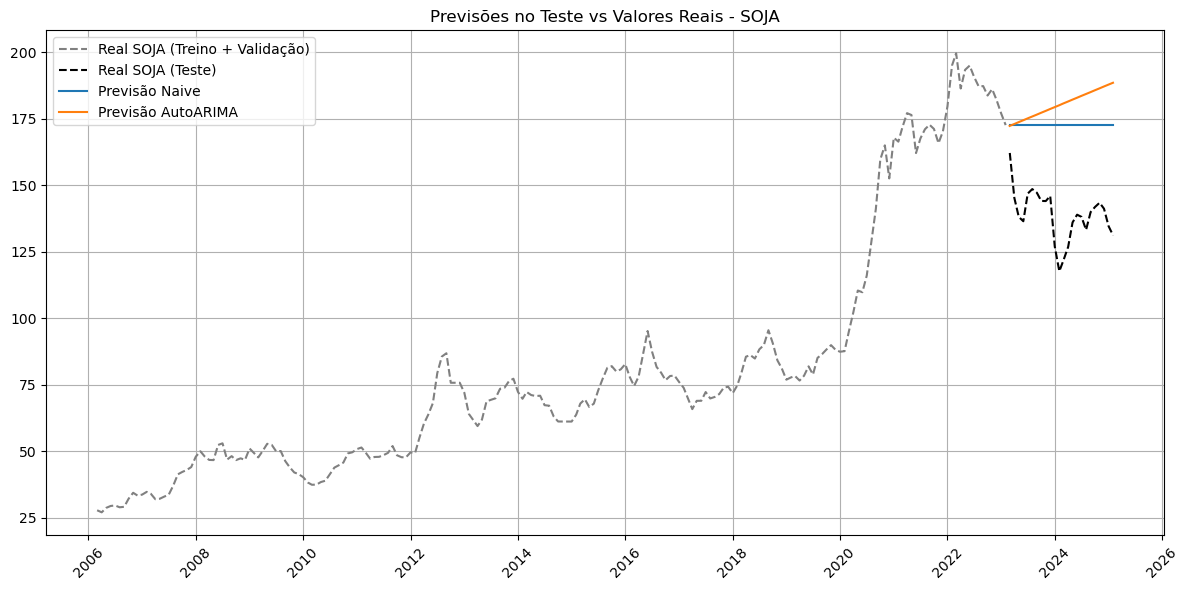

In [18]:
for commodity in Y_test_df_brl['unique_id'].unique():
    plot_test_forecasts(
        full_train=full_train,
        test_data=Y_test_df_brl,
        forecasts_test=forecasts_test,
        commodity=commodity
    )

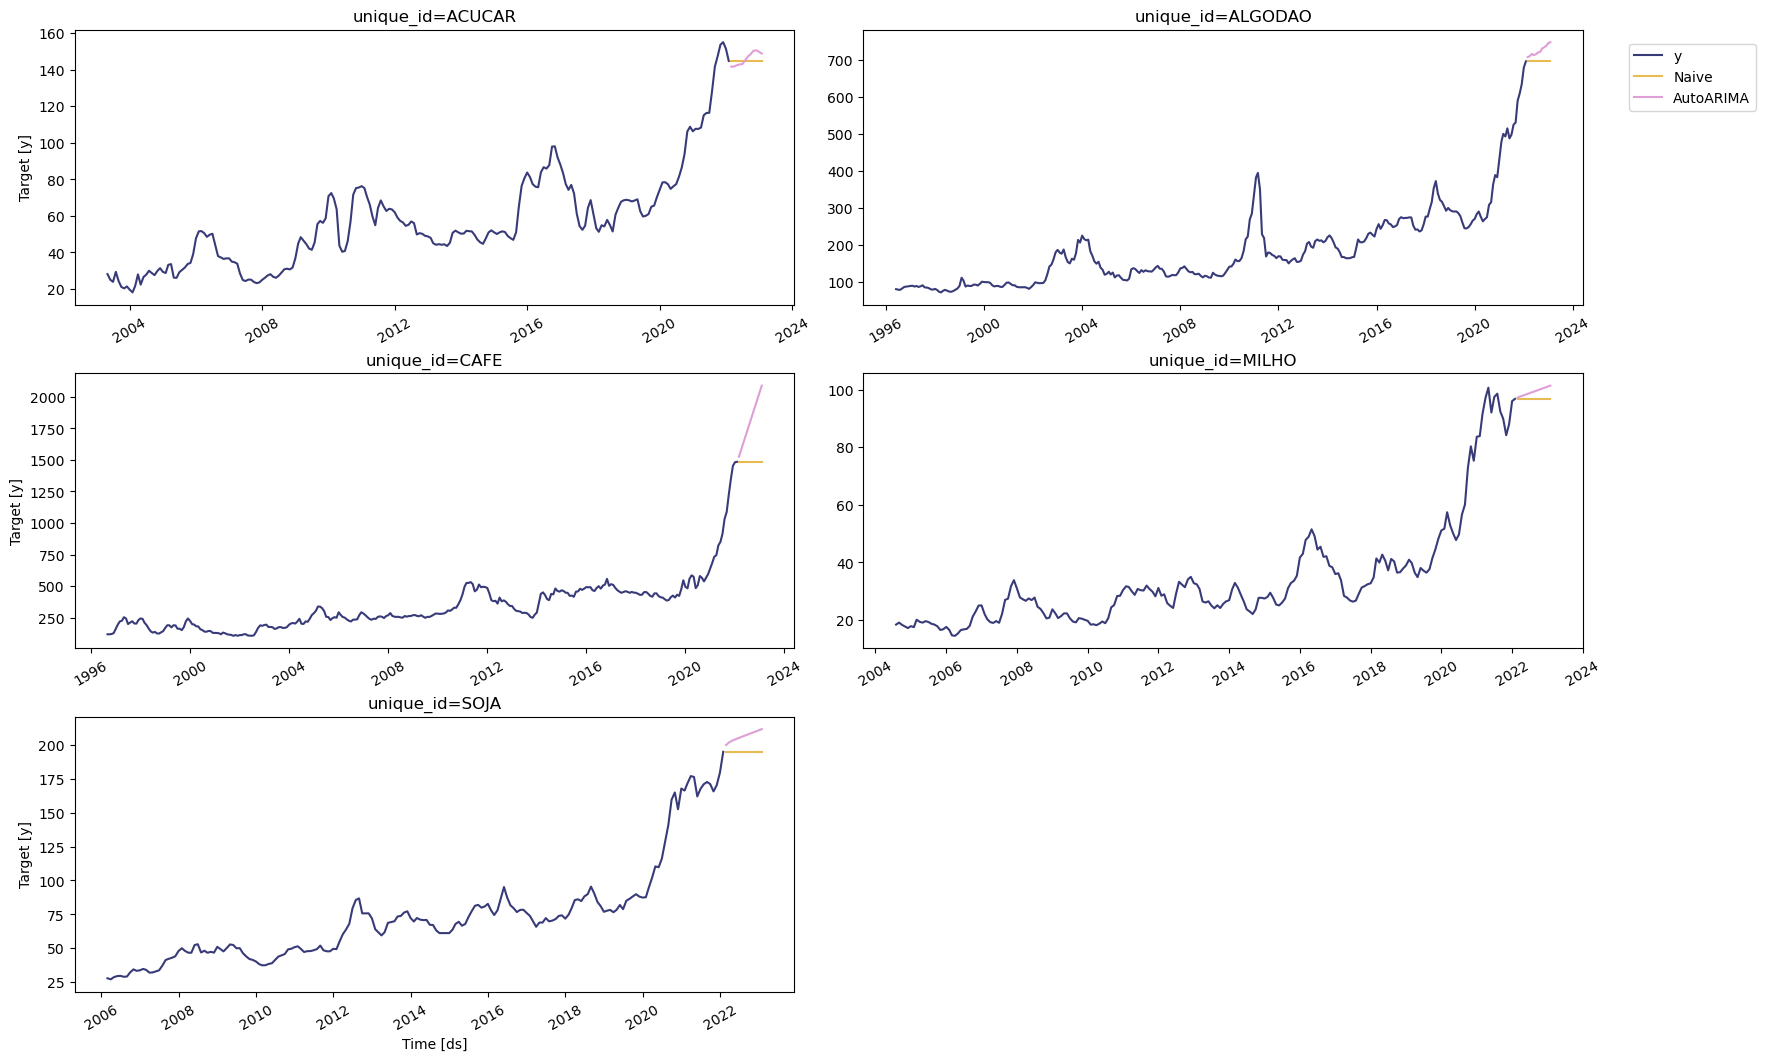

In [19]:
sf.plot(X_train_df_brl,forecasts_val)

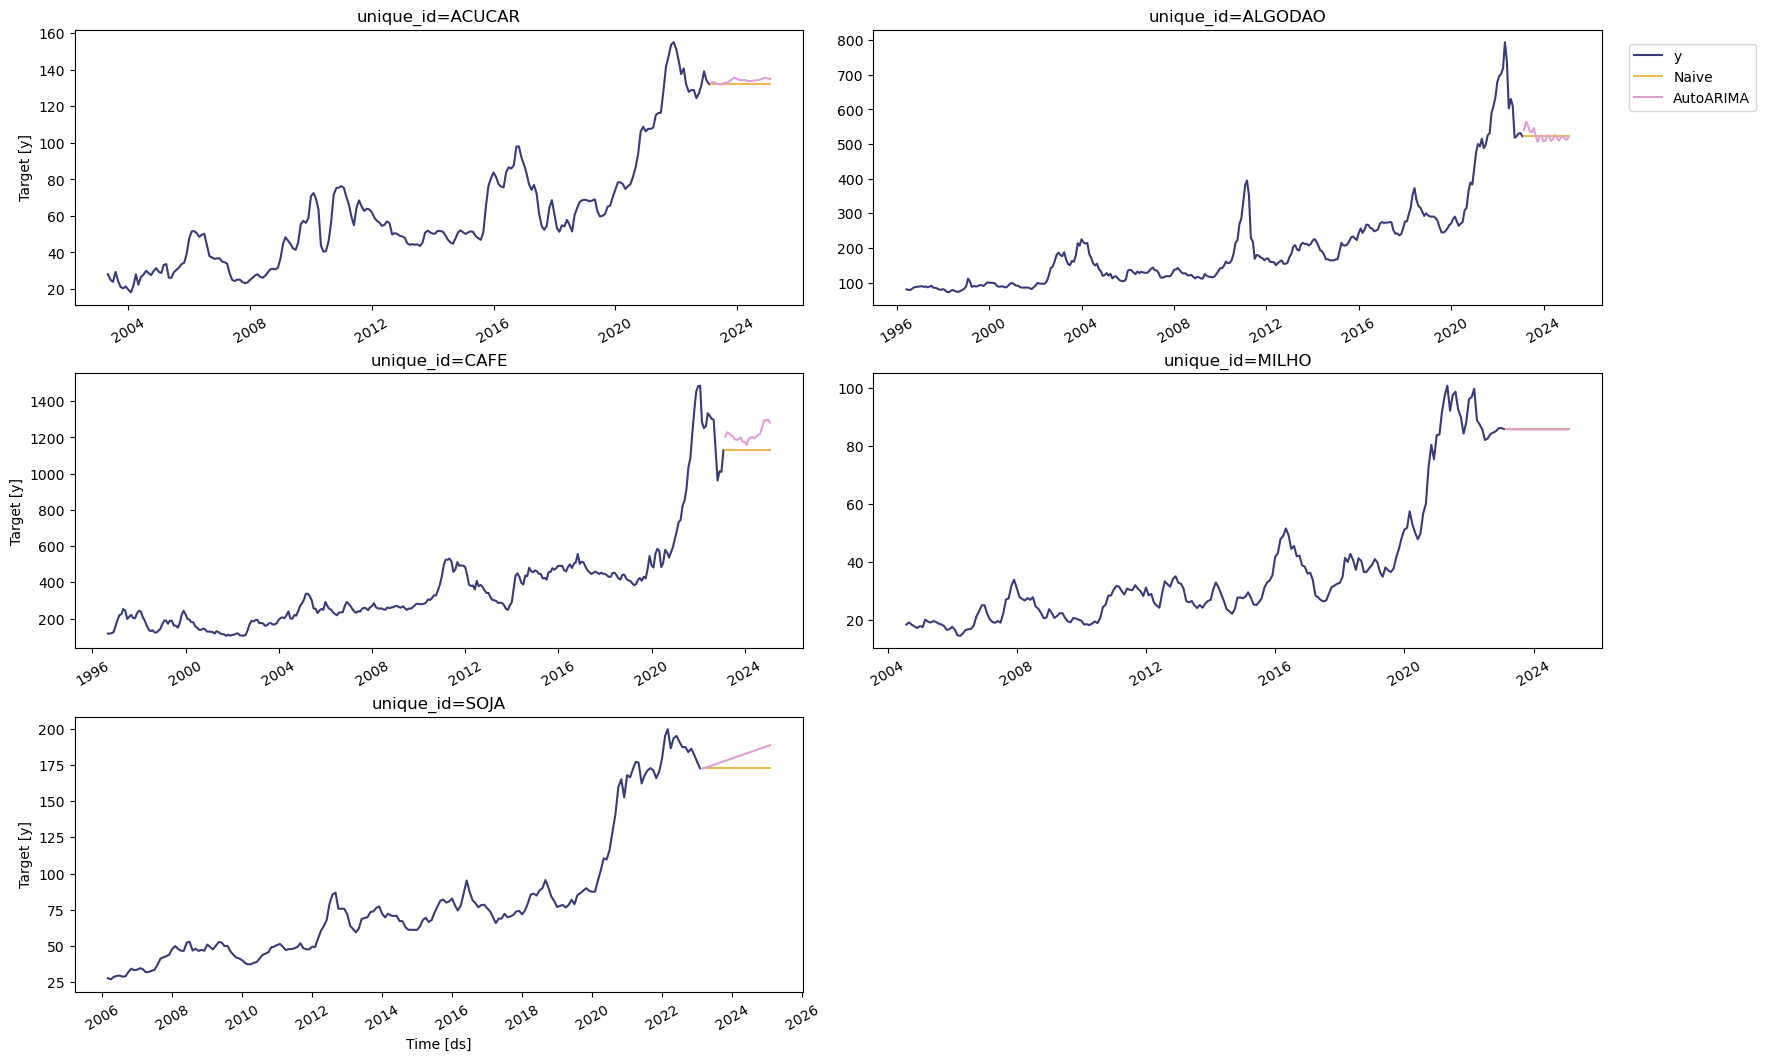

In [20]:
sf.plot(full_train,forecasts_test)

### USD